In [1]:
# Few base imports and logging.

import logging
import functools
import itertools

import numpy as np
logging.basicConfig()
logger = logging.getLogger('vd')
logger.setLevel(logging.DEBUG)

# make sure you have the pep8_magic installed
# jupyter nbextension install --user pep8_magic.py
%load_ext pep8_magic

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from skimage.exposure import equalize_adapthist
from skimage.transform import resize
from skimage.color import rgb2ycbcr
from scipy.misc import imsave
import cv2
import glob

# Few helper functions
def show_images(images,titles=None, save=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if len(image.shape) == 2 or image.shape[2] == 1: # Is image grayscale?
            plt.imshow(np.resize(image, (image.shape[0], image.shape[1])), interpolation="bicubic", cmap="gray") # Only place in this blog you can't replace 'gray' with 'grey'
        else:
            plt.imshow(image, interpolation="bicubic")
        if titles is not None:
            a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.tight_layout()
    plt.show()
    if save is not None:
        fig.savefig("examples/" + save + ".png")
        

def extract_frames(clip, times, imgdir, imgname):
    for t in times:
        imgpath = os.path.join(imgdir, '{}-{}.jpg'.format(imgname, t))
        clip.save_frame(imgpath, t)
        
def resize(image, c=(32, 32)):
    return cv2.resize(image, c)

def img_color_spaces(img_rgb):
    return [(img_rgb, "RGB"), (cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV), "HSV"),
            (cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LUV), "LUV"),
            (cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS), "HLS"),
            (cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV), "YUV")]

def load_img(img_fname):
    return cv2.cvtColor(cv2.imread(img_fname,  cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
                
def draw_box(img_fname, c1, c2):
    return cv2.rectangle(load_img(img_fname), c1, c2, (0,255,0), 4)
    
def output_image(img, img_name, prefix="examples"):
    imsave(str(prefix) + "/" + str(img_name) + ".png", img)
    
def get_rnd(l):
    return l[np.random.randint(len(l), size=1)[0]]

### Download the provided data

This code block downloads the data and unzip into given location.
This is optionally run.

The data sets used are [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip). 

Optionally the larger data 1 set provided [here](http://bit.ly/udacity-annoations-crowdai) from [self-driving-car/annotations/](https://github.com/udacity/self-driving-car/tree/master/annotations)

In [3]:
#%%pep8

import urllib.request
import urllib.parse
import urllib.error

from pathlib import Path


def download_data(from_url, file_name, to_dir="data", retry=False):
    to_path = '{}/{}'.format(str(to_dir), str(file_name))
    if retry is True or Path(to_path).is_file() is False:
        logger.info("downloading {}".format(from_url))
        f = urllib.request.urlopen(from_url)
        data = f.read()
        with open(to_path, "wb") as d:
            logger.info("writing data to: {}".format(to_path))
            d.write(data)
download_data(
    "https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip",
    "vehicles.zip")
download_data(
    "https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip",
    "non-vehicles.zip")
download_data(
    "https://github.com/udacity/self-driving-car/blob/master/annotations/labels_crowdai.csv",
    "labels_crowdai.csv")
download_data(
    "http://bit.ly/udacity-annoations-crowdai",
    "object-detection-crowdai.tar")

### Extract the data

This code block extracts the above downloaded data.

In [4]:
#%%pep8

import zipfile
import tarfile

data_files = ["vehicles.zip", "non-vehicles.zip", "object-detection-crowdai.tar"]


def extract_file(zfile, prefix_dir="data", retry=False):
    tdir = zfile.split('.')[0]
    f = '{}/{}'.format(str(prefix_dir), str(zfile))
    to_path = '{}'.format(str(prefix_dir))
    check_path = '{}/{}'.format(to_path, tdir)
    if retry is True or Path(check_path).is_dir() is False:
        logger.info("Extracting {} to {}/".format(f, to_path))
        zip_ref = None
        if (f.endswith("tar.gz")):
            zip_ref = tarfile.open(f, "r:gz")
        elif (f.endswith("tar")):
            zip_ref = tarfile.open(f, "r:")
        elif (f.endswith("zip")):
            zip_ref = zipfile.ZipFile(f, "r")
    
        if zip_ref is None:
            err_str = "Invalid compressed file: {}".format(f)
            logger.error(err_str)
            raise Exception(err_str)

        zip_ref.extractall(to_path)
        zip_ref.close()
    return check_path

data_dirs = [ extract_file(x) for x in data_files ]

### Load and inspect the default dataset provided

Show few examples and see how they look like

In [5]:
vehicle_images = [load_img(x) for x in glob.glob("{}/*/*.png".format(data_dirs[0]))]
non_vehicle_images = [load_img(x) for x in glob.glob("{}/*/*.png".format(data_dirs[1]))]
print("Number if images in dataset[{}] is {}".format(data_dirs[0], len(vehicle_images)))
print("Number if images in dataset[{}] is {}".format(data_dirs[1], len(non_vehicle_images)))
print("Shape of image: {}".format(vehicle_images[0].shape))

Number if images in dataset[data/vehicles] is 8792
Number if images in dataset[data/non-vehicles] is 8968
Shape of image: (64, 64, 3)


In [6]:
from skimage.feature import hog
from skimage import data, color, exposure

def get_hog(img, visualise=False, feature_vector=True):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    img_gray = color.rgb2gray(img)

    fd = hog(img_gray,
             orientations=orient,
             pixels_per_cell=(pix_per_cell, pix_per_cell),
             cells_per_block=(cell_per_block, cell_per_block),
             visualise=visualise, feature_vector=feature_vector)
    return fd

def rescale_intensity(hog_image):
    # Rescale histogram for better display
    return exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

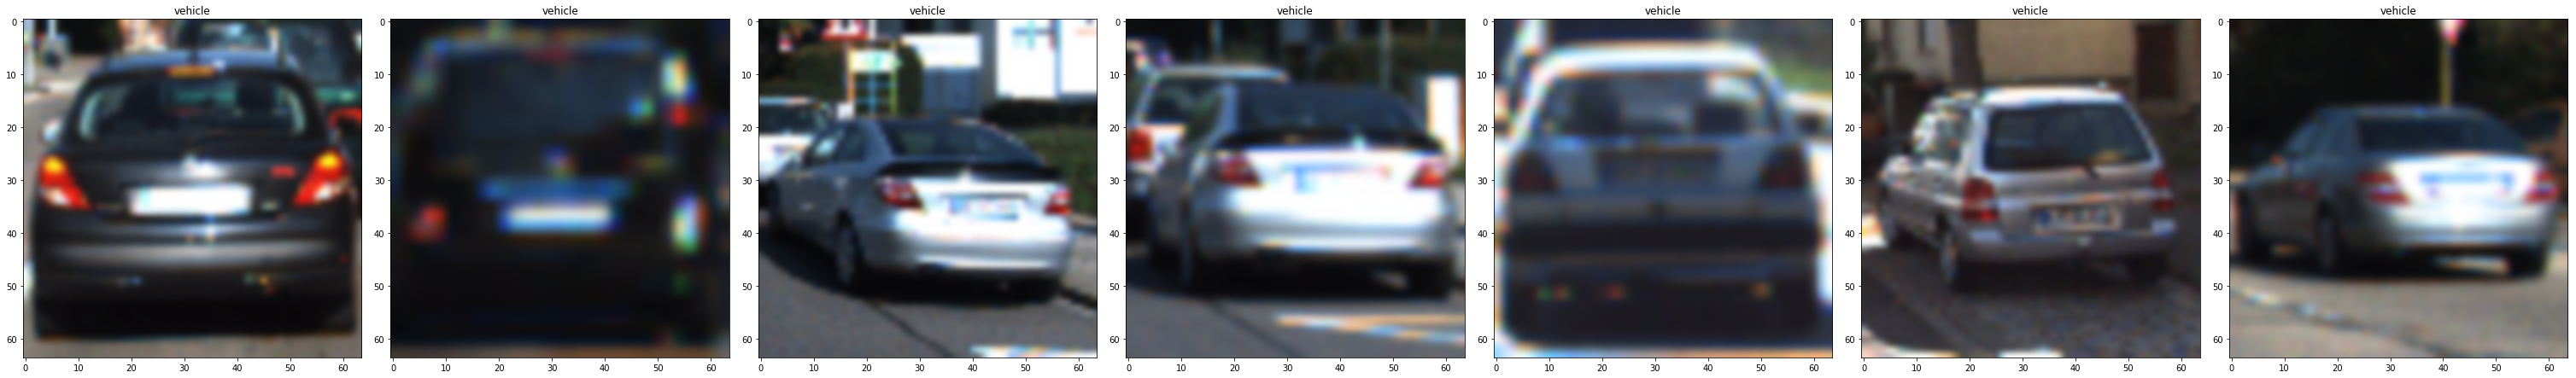

/home/powell/ENTER/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


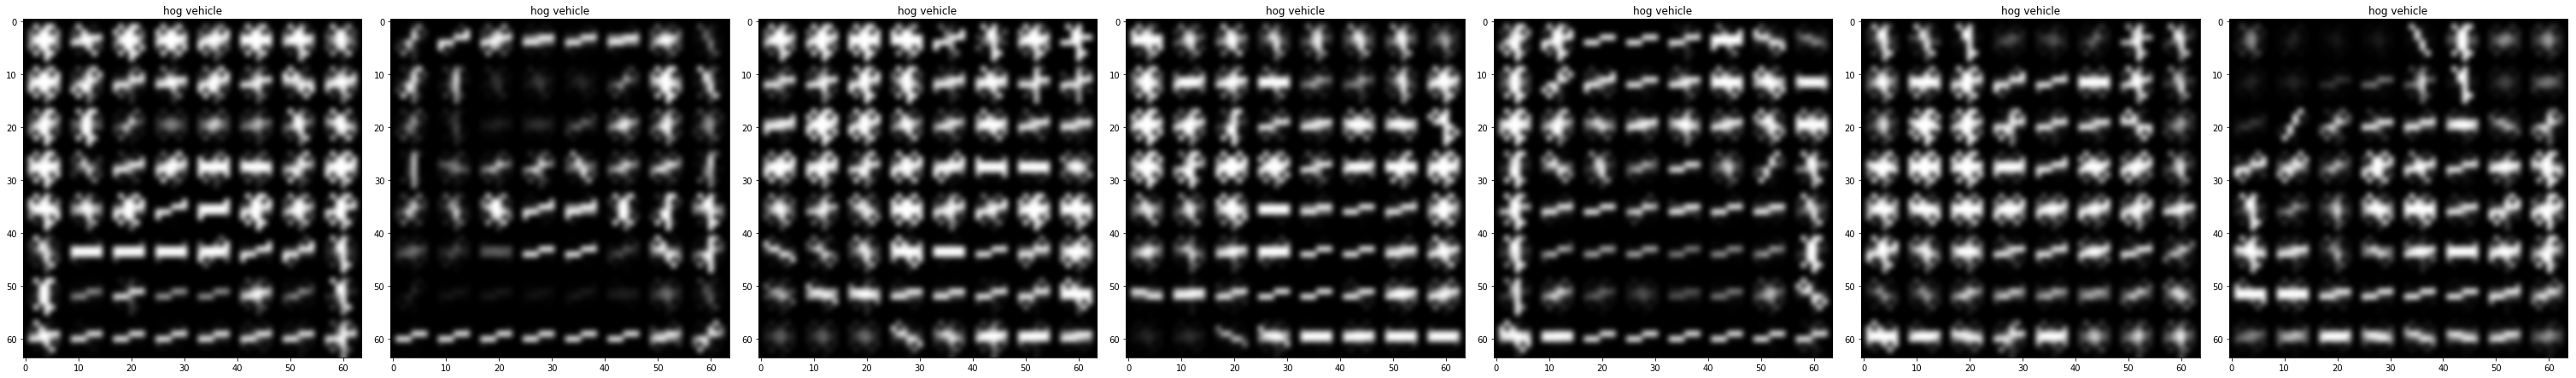

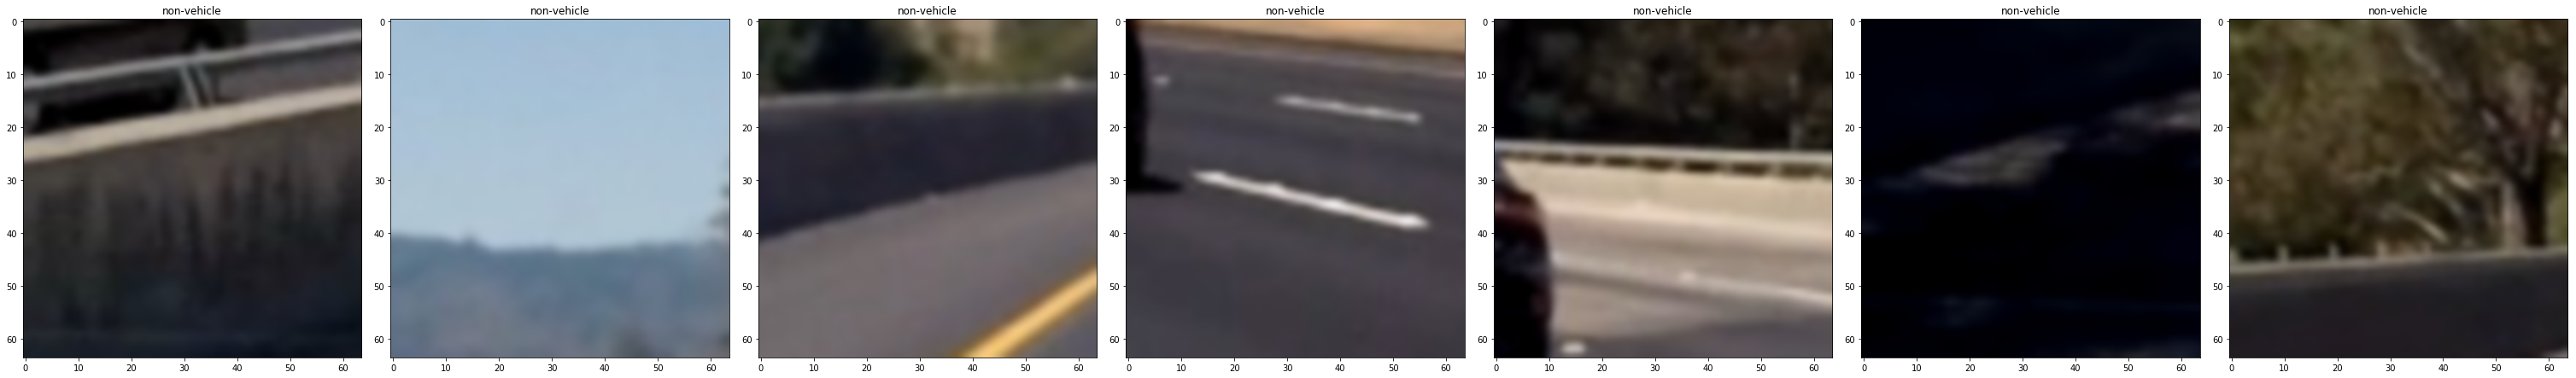

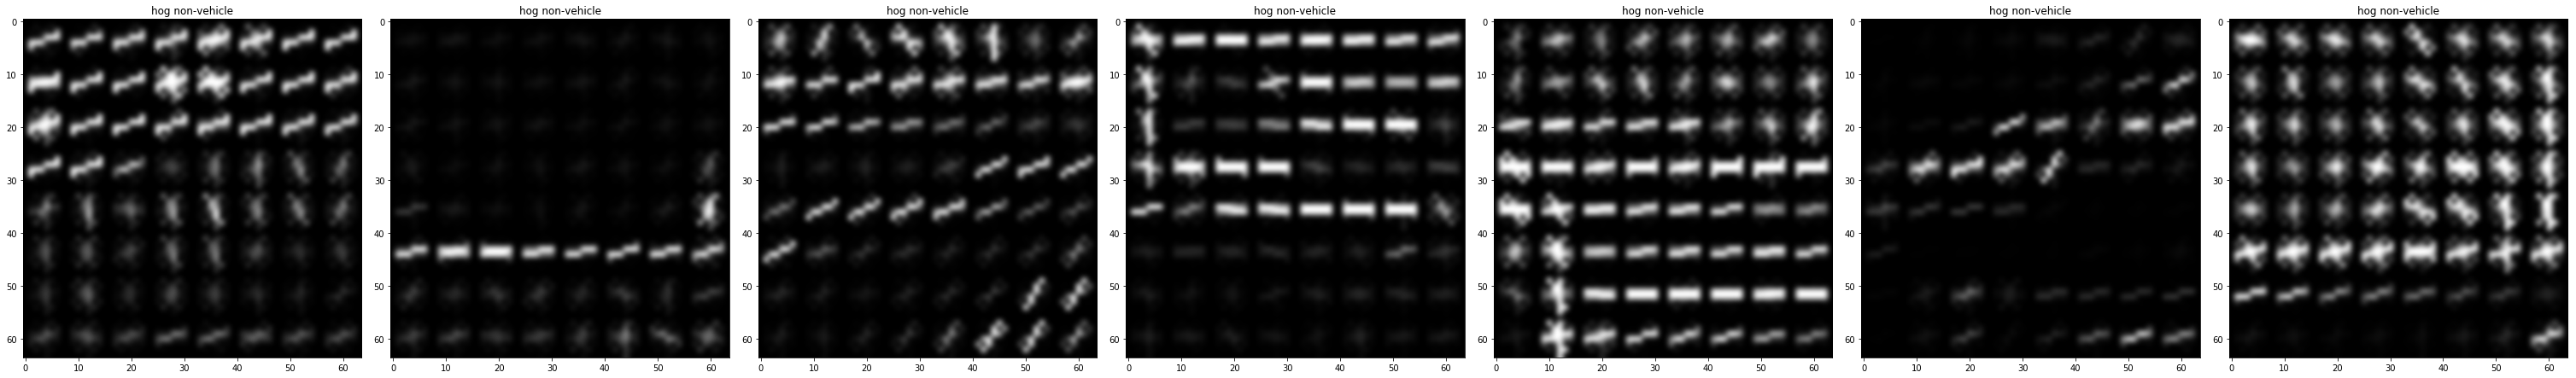

In [7]:
show_images(vehicle_images[1:8], ["vehicle"]*8)
show_images([rescale_intensity(get_hog(x, visualise=True)[1]) for x in vehicle_images[1:8]], ["hog vehicle"]*8)

show_images(non_vehicle_images[1:8], ["non-vehicle"]*8)
show_images([rescale_intensity(get_hog(x, visualise=True)[1]) for x in non_vehicle_images[1:8]], ["hog non-vehicle"]*8)

### Process additional data

### Crop and resize additional data

The additional large data 1 set provided [here](http://bit.ly/udacity-annoations-crowdai) from [self-driving-car/annotations/](https://github.com/udacity/self-driving-car/tree/master/annotations) needs cropping based on
the data in the **labels.csv** file.

Example:
```
xmin,xmax,ymin,ymax,Frame,Label,Preview URL
785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/visualize
89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/visualize
```

In [8]:
#%%pep8

import csv


def process_csv(prefix, fname,
                row_labels=('Frame', 'Label', 'xmin',
                            'xmax', 'ymin', 'ymax')):
    fpath = '{}/{}'.format(prefix, "labels.csv")
    with open(fpath) as csvfile:
        reader = csv.DictReader(csvfile)
        ret = []
        for row in reader:
            v = ['{}/{}'.format(prefix, row['Frame']), row['Label']]
            v.append((int(row['xmin']), int(row['xmax'])))  # xmax is actually ymin
            v.append((int(row['ymin']), int(row['ymax'])))  # ymin is actually xmax
            ret.append(v)
    return ret, row_labels


r, header = process_csv(data_dirs[2], 'labels.csv')

logger.debug(header)
logger.debug(r[0])
logger.debug(r[1])

DEBUG:vd:('Frame', 'Label', 'xmin', 'xmax', 'ymin', 'ymax')
DEBUG:vd:['data/object-detection-crowdai/1479498371963069978.jpg', 'Car', (785, 533), (905, 644)]
DEBUG:vd:['data/object-detection-crowdai/1479498371963069978.jpg', 'Car', (89, 551), (291, 680)]


Number of samples: 72064
Shape of image: (1200, 1920, 3)
Classes: ['Car' 'Pedestrian' 'Truck']


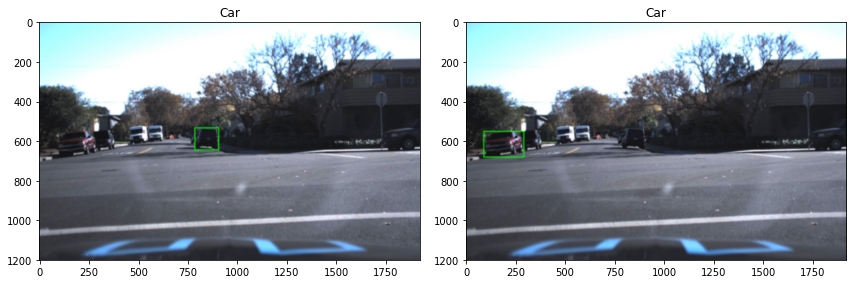

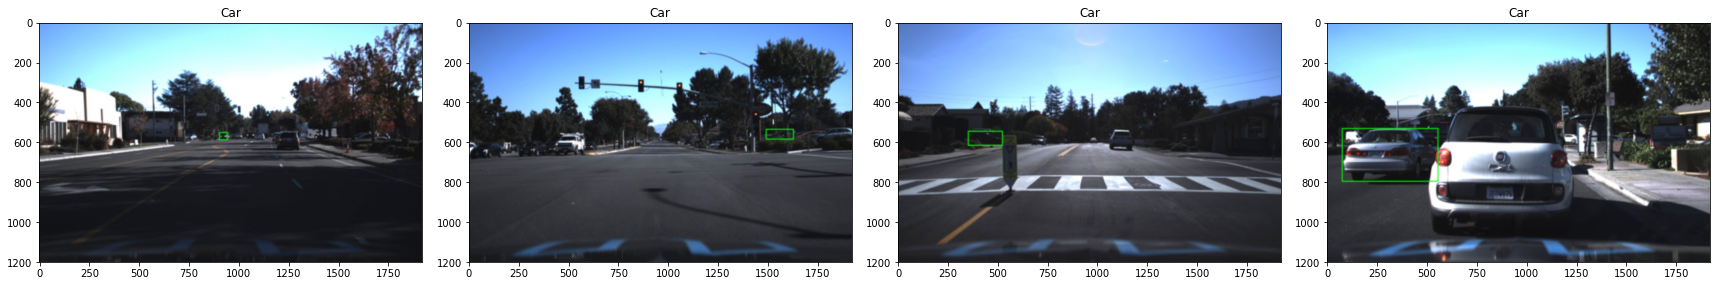

In [9]:
# Show size of the data set
print("Number of samples: {}".format(len(r)))

# Shape of a image
print("Shape of image: {}".format(load_img(r[0][0]).shape))

# Unique classes
print("Classes: {}".format(np.unique([x[1] for x in r])))

# Draw boxes on the first two images.
img_idxs = [ 0, 1 ]

imgs = [ draw_box(r[i][0], r[i][2], r[i][3]) for i in img_idxs ]
imgs_label = [ r[i][1] for i in img_idxs ]

show_images(imgs, imgs_label)

# Pick few random images and draw a rectange around the object
img_idxs = np.random.choice(len(r), 4)
imgs = [ draw_box(r[i][0], r[i][2], r[i][3]) for i in img_idxs ]
imgs_label = [ r[i][1] for i in img_idxs ]

show_images(imgs, imgs_label)

### Visualization of given data

#### Explore various color spaces

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

In [11]:
def plot_color_spaces(img, img_title):
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = img_small
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_RGB2LUV)
    img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_RGB2YUV)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    show_images([img], [img_title])
    # Plot and show
    plot3d(img_small_RGB, img_small_rgb)
    plt.title("RGB")
    plt.show()

    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.title("HSV")
    plt.show()
    
    plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
    plt.title("LUV")
    plt.show()
    
    plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
    plt.title("YUV")
    plt.show()

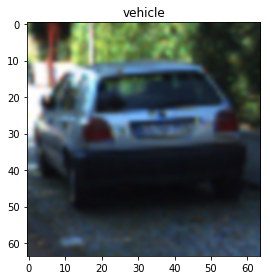

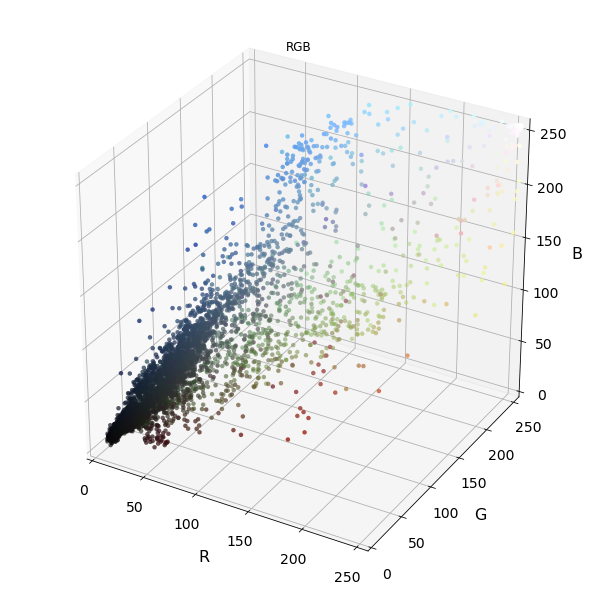

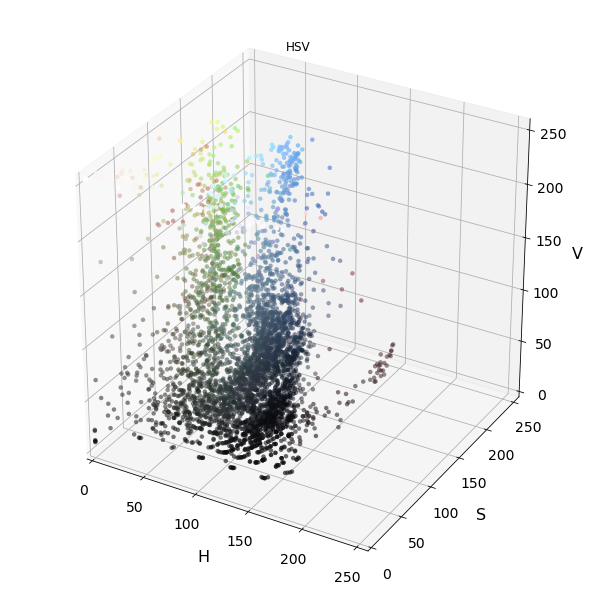

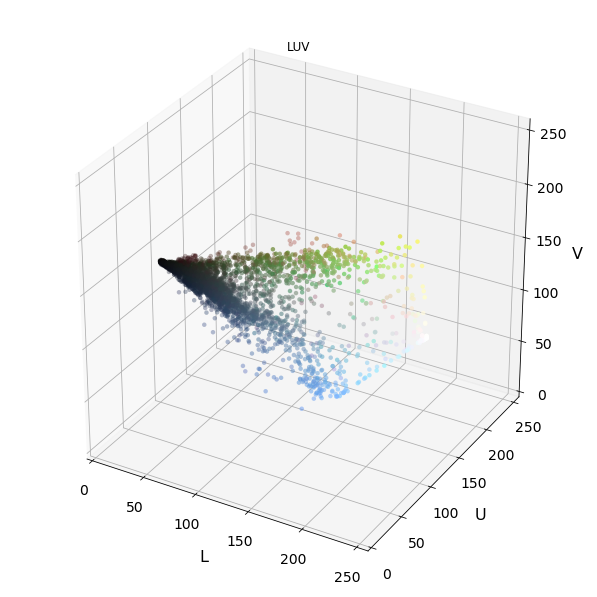

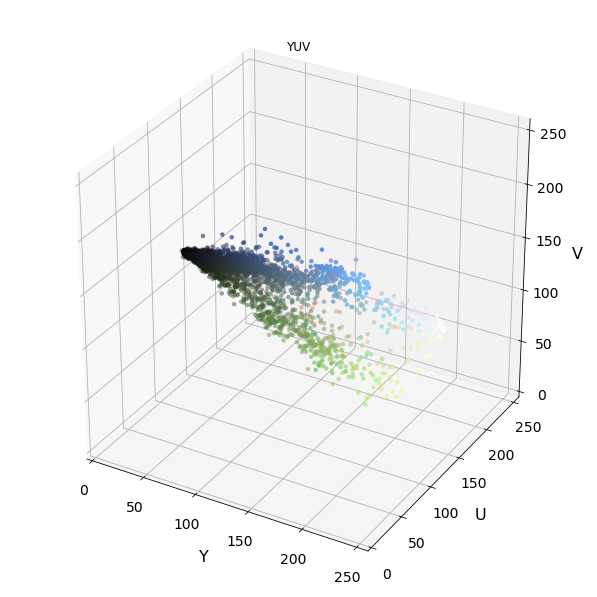

In [12]:
plot_color_spaces(get_rnd(vehicle_images), "vehicle")

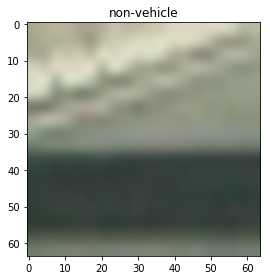

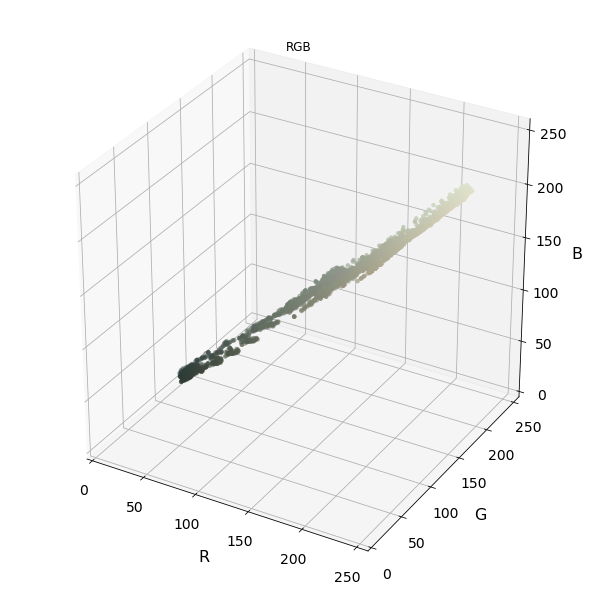

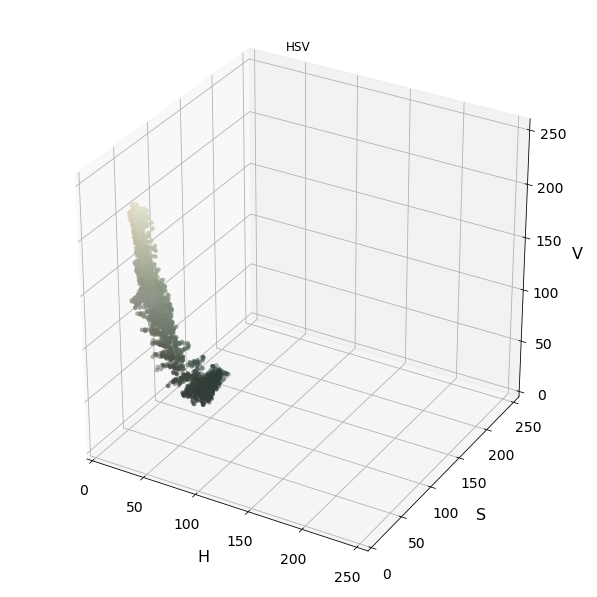

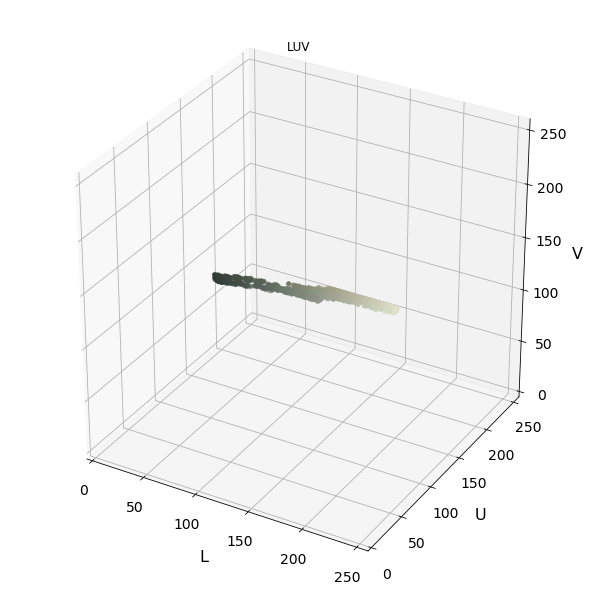

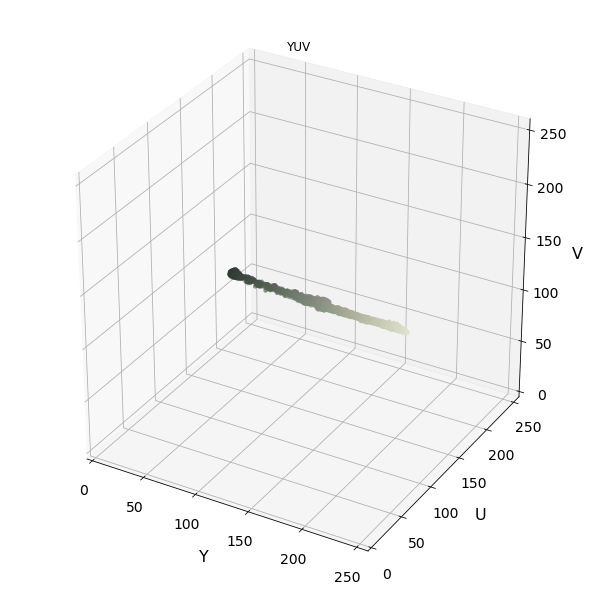

In [13]:
plot_color_spaces(get_rnd(non_vehicle_images), "non-vehicle")

#### Color histogram for various color spaces

In [14]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

def plot_color_hist(image, title, color_space="RGB"):
    rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))
    i, j, k = cv2.split(image)
    if rh is not None:
        fig = plt.figure(figsize=(12,8))
        plt.subplot(231)
        plt.imshow(i, cmap='gray', interpolation="bicubic")
        plt.title('{}'.format(color_space[0]))
        plt.subplot(232)
        plt.imshow(j, cmap='gray', interpolation="bicubic")
        plt.title('{}'.format(color_space[1]))
        plt.subplot(233)
        plt.imshow(k, cmap='gray', interpolation="bicubic")
        plt.title('{}'.format(color_space[2]))
        plt.subplot(234)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title('{} Histogram'.format(color_space[0]))
        plt.subplot(235)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title('{} Histogram'.format(color_space[1]))
        plt.subplot(236)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title('{} Histogram'.format(color_space[2]))
        fig.suptitle(title, fontsize=10)
        fig.tight_layout()
    else:
        logger.error("None returned by color_hist for image")
        
def plot_color_spaces_hist(img, title):
    [plot_color_hist(x[0], title, x[1]) for x in img_color_spaces(img)]
    

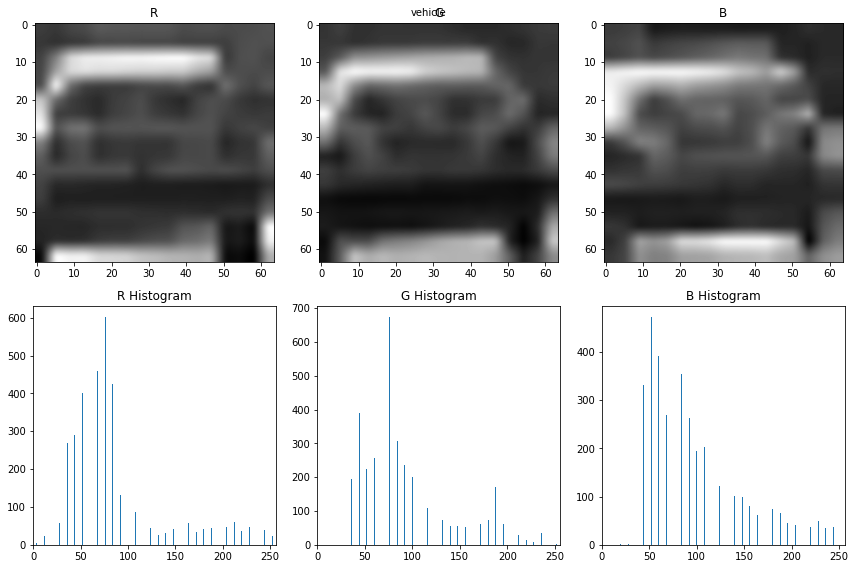

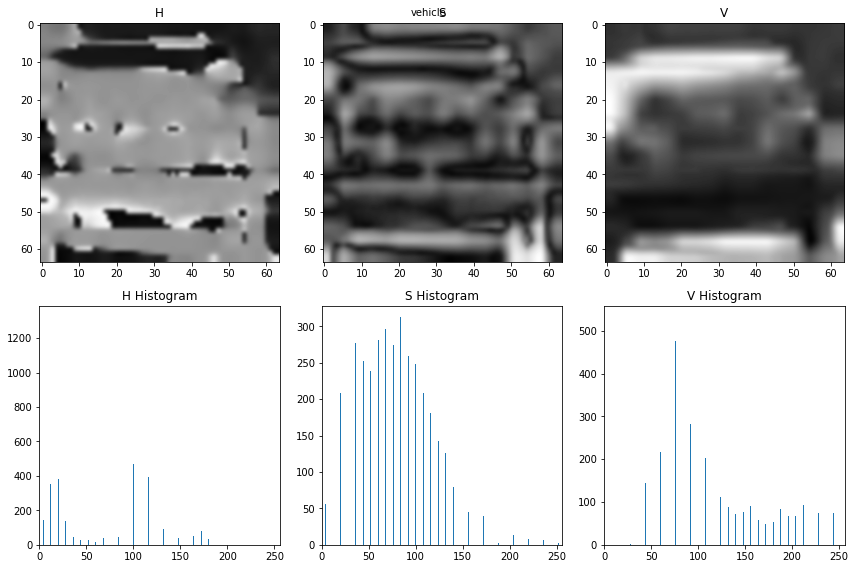

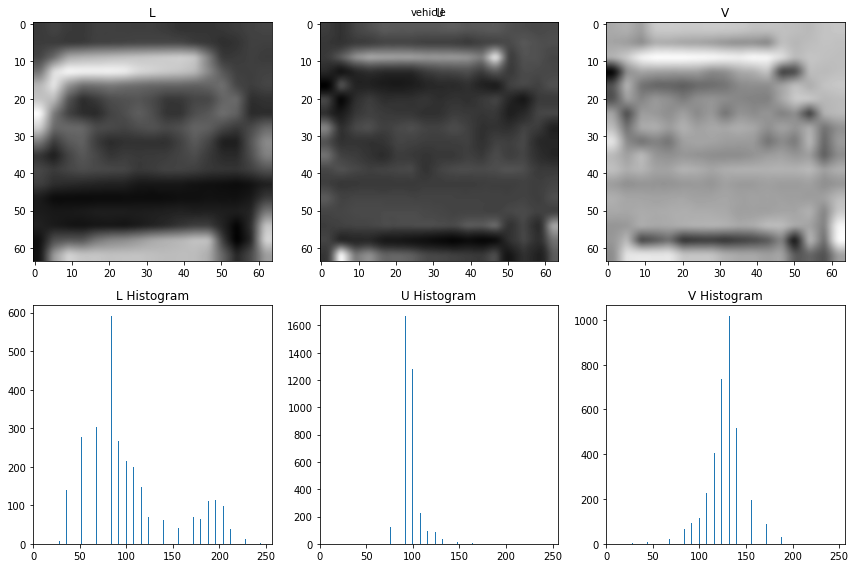

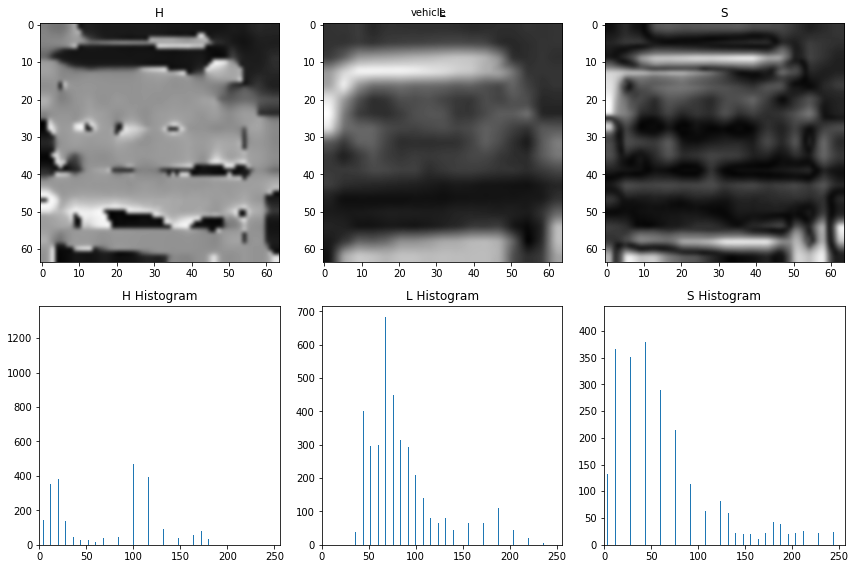

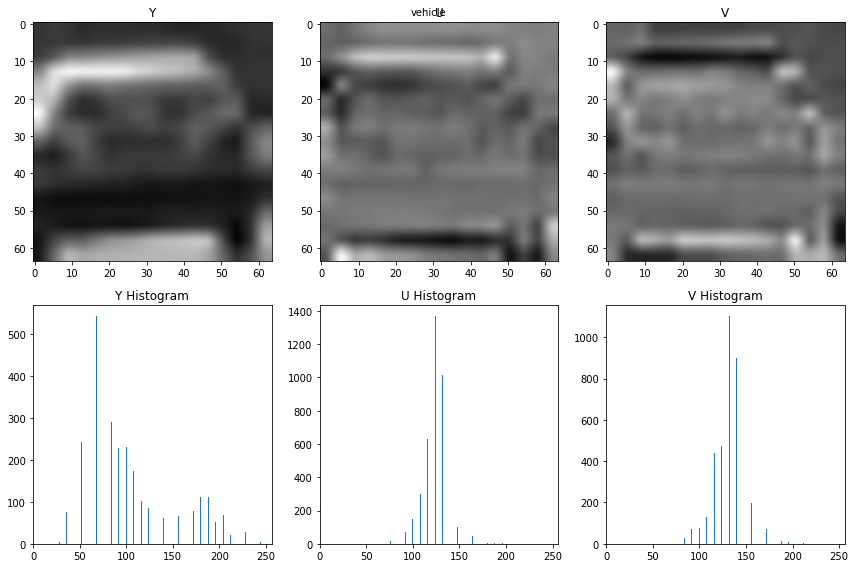

In [15]:
plot_color_spaces_hist(get_rnd(vehicle_images), "vehicle")

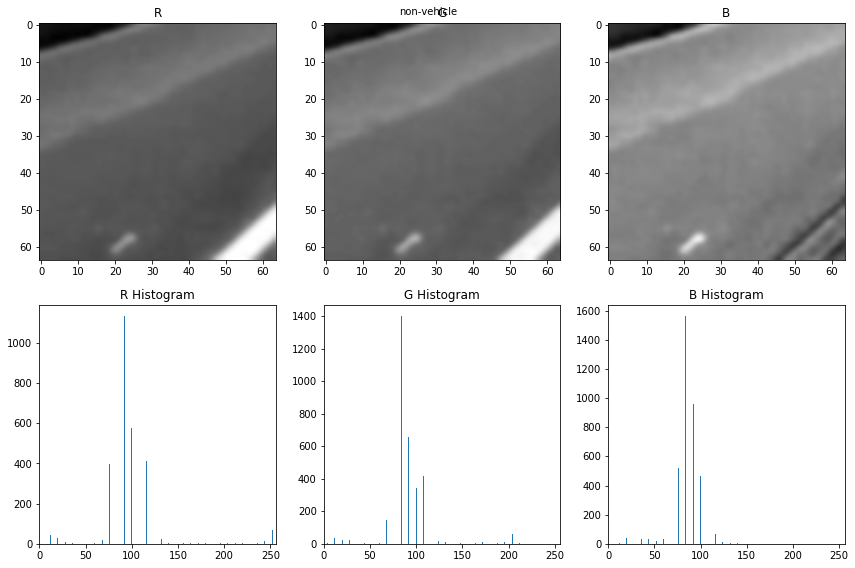

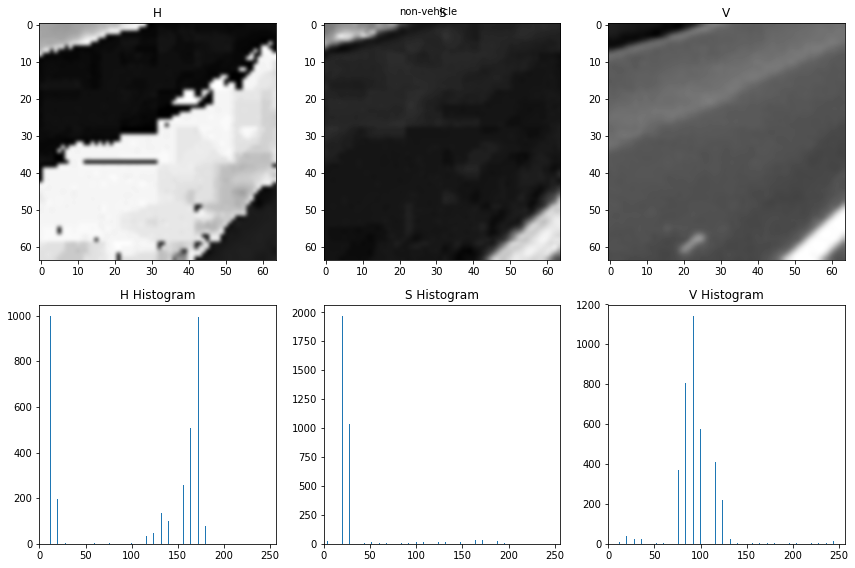

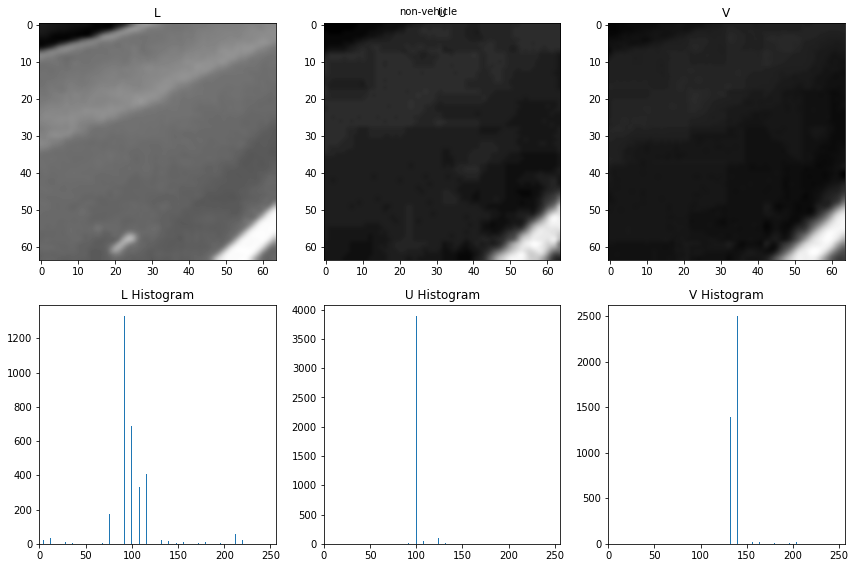

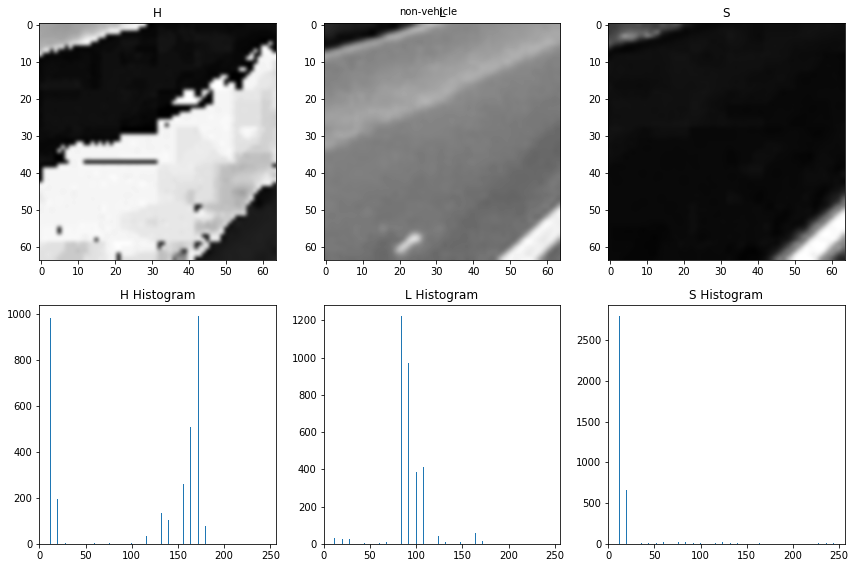

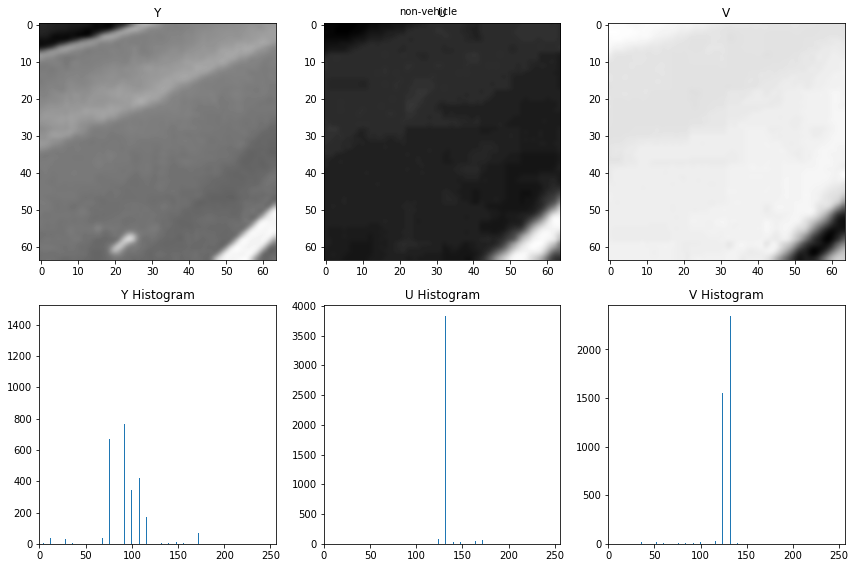

In [16]:
plot_color_spaces_hist(get_rnd(non_vehicle_images), "non-vehicle")

#### Spatially Spatial Binning of Color

In [17]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

def plot_bin_spatial(img, title):
    f = plt.figure()
    plt.subplot(211)
    plt.imshow(img, interpolation="bicubic")
    plt.subplot(212)
    plt.plot(bin_spatial(img, color_space='HSV'))
    f.suptitle(title, fontsize=10)
    f.tight_layout()


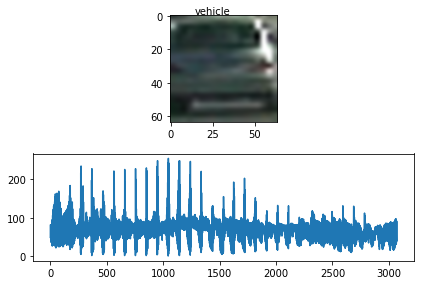

In [18]:
plot_bin_spatial(get_rnd(vehicle_images), "vehicle")

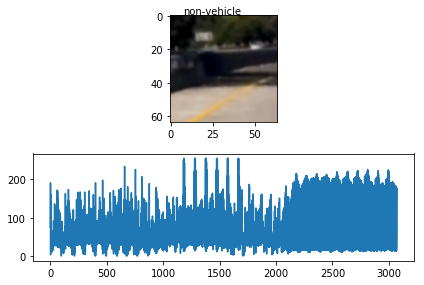

In [19]:
plot_bin_spatial(get_rnd(non_vehicle_images), "non-vehicle")

### Combine features

As mentioned in the lesson combine various feature vectors and use StandardScaler() to scale them.

In [20]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        _, _, _, _, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # hog features
        hog_features = get_hog(image)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [21]:
from sklearn.preprocessing import StandardScaler

def get_features_scaled(cspace='HSV', spatial_size=(32, 32)):
    vehicle_features = extract_features(vehicle_images, cspace=cspace, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
    non_vehicle_features = extract_features(non_vehicle_images, cspace=cspace, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
    
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
    return scaled_X, y, X

def plot_scaled(cars, scaled_X, X):
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(cars[car_ind])
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

In [22]:
scaled_X, y, X = get_features_scaled()

/home/powell/ENTER/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


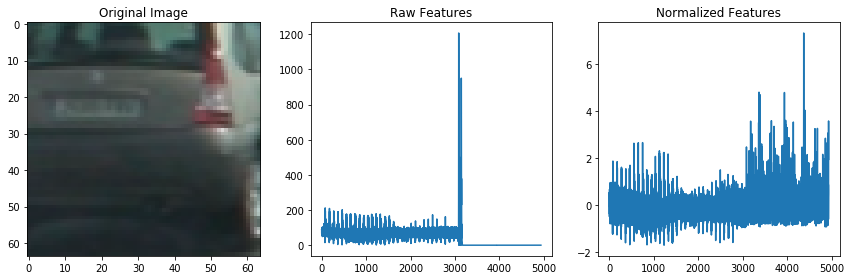

In [23]:
plot_scaled(vehicle_images, scaled_X, X)

### Train SVM model

In [24]:
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def model_SVM_train(scaled_X, y):
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = SVC()
    # Check the training time for the SVC
    clf = RandomizedSearchCV(svc, parameters, n_iter=4, n_jobs=8)
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    return clf, X_test, y_test

def model_SVM_test(clf, X_test, y_test):
    print("SVM parametrs {}".format(clf.best_params_))
    print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [25]:
clf, X_test, y_test = model_SVM_train(scaled_X, y)

660.01 Seconds to train SVC...


In [26]:
model_SVM_test(clf, X_test, y_test)

SVM parametrs {'kernel': 'rbf', 'C': 10}
Test Accuracy of SVC =  0.9977
My SVC predicts:  [ 1.  0.  1.  1.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  0.  0.  1.  0.  1.]
0.10389 Seconds to predict 10 labels with SVC
